Classification Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.97       233
           1       0.94      0.91      0.93        34
           2       1.00      0.67      0.80         6
           3       0.95      0.94      0.95      2993
           4       0.97      0.97      0.97      5952

    accuracy                           0.96      9218
   macro avg       0.97      0.89      0.92      9218
weighted avg       0.96      0.96      0.96      9218

Regression MSE: 0.00, R² Score: 1.00

🔹 Final Combined Predictions:
       Predicted Fuel Type  Predicted Mileage (MPG)
0                       4                     21.0
1                       4                     16.0
2                       3                     20.0
3                       3                     28.0
4                       4                     14.0
...                   ...                      ...
9213                    3      

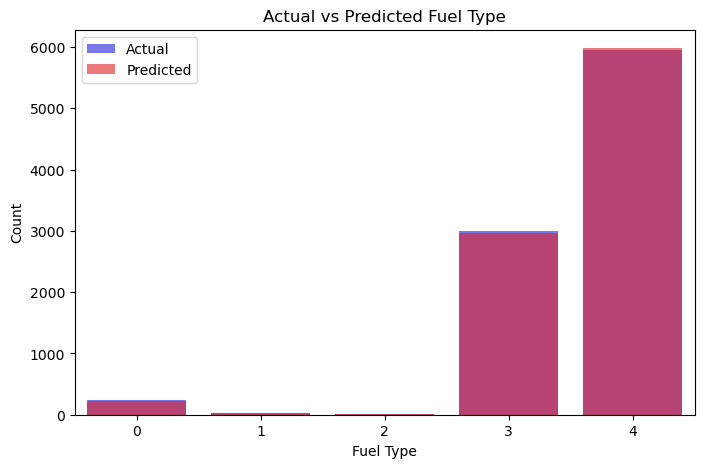

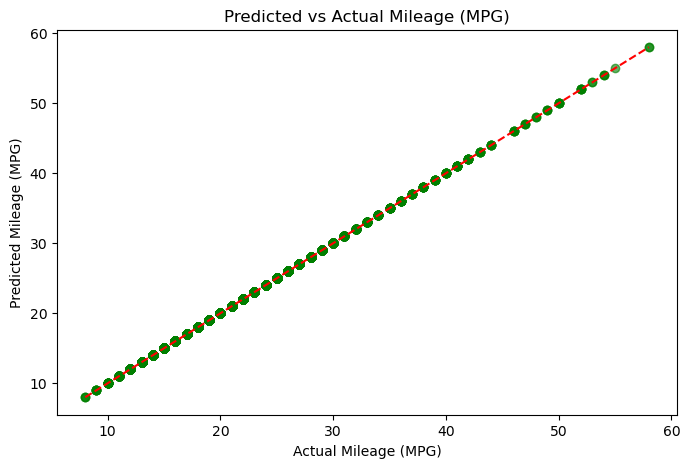

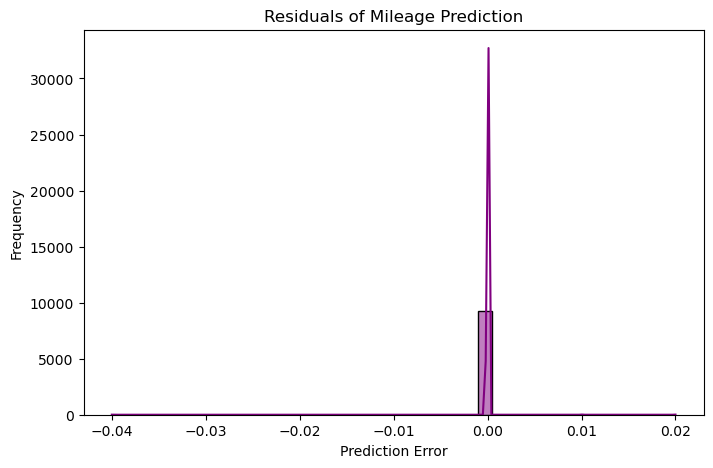

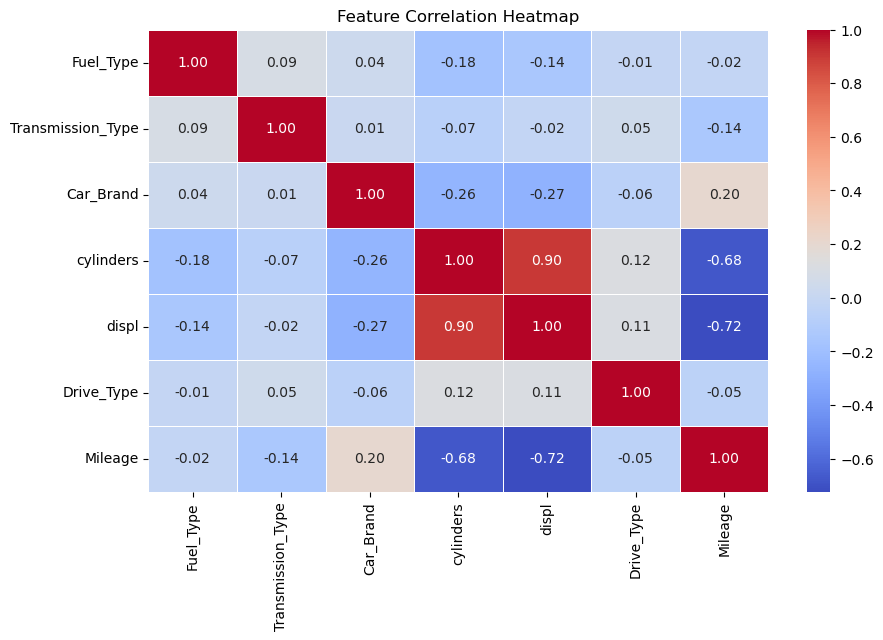

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score

# 🔹 Load dataset (suppress dtype warnings)
df = pd.read_csv(r"C:/Users/adity/Downloads/vehicles.csv", low_memory=False)

# 🔹 Select Relevant Columns
df = df[["fuelType1", "trany", "make", "cylinders", "displ", "drive", "comb08"]]  # Keeping essential features

# 🔹 Handle Missing Values
df.dropna(inplace=True)  # Remove rows with missing values

# 🔹 Rename Columns for Consistency
df.rename(columns={"fuelType1": "Fuel_Type", "trany": "Transmission_Type", "make": "Car_Brand", 
                   "comb08": "Mileage", "drive": "Drive_Type"}, inplace=True)

# 🔹 Encode Categorical Variables
categorical_cols = ["Fuel_Type", "Transmission_Type", "Car_Brand", "Drive_Type"]

for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))  # Convert to numerical

# 🔹 Step 1: Train Classification Model (Predict Fuel Type)
X_class = df.drop("Fuel_Type", axis=1)  # Features for classification
y_class = df["Fuel_Type"]  # Target (Fuel Type)

X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42
)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_class_train, y_class_train)
y_class_pred = rf_classifier.predict(X_class_test)             

# 🔹 Convert numeric predictions back to original Fuel Type labels
y_class_pred_labels = LabelEncoder().fit(df["Fuel_Type"]).inverse_transform(y_class_pred)

# 🔹 Evaluate Classification Model
accuracy = accuracy_score(y_class_test, y_class_pred)
print(f"Classification Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_class_test, y_class_pred))

# 🔹 Step 2: Use Classification Output as Input for Regression (Predict Mileage)
df_reg_train = X_class_train.copy()
df_reg_test = X_class_test.copy()

df_reg_train["Predicted_Fuel_Type"] = rf_classifier.predict(X_class_train)  # Use trained classifier predictions
df_reg_test["Predicted_Fuel_Type"] = y_class_pred  # Use test set predictions

# 🔹 Define Features and Target for Regression
X_reg_train = df_reg_train  # Features for regression
X_reg_test = df_reg_test  # Features for regression test
y_reg_train = df.loc[X_reg_train.index, "Mileage"]  # Target (Mileage)
y_reg_test = df.loc[X_reg_test.index, "Mileage"]  # Target for test set

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_reg_train, y_reg_train)
y_reg_pred = rf_regressor.predict(X_reg_test)

# 🔹 Evaluate Regression Model
mse = mean_squared_error(y_reg_test, y_reg_pred)
r2 = r2_score(y_reg_test, y_reg_pred)
print(f"Regression MSE: {mse:.2f}, R² Score: {r2:.2f}")

# 🔹 Final Results
final_results = pd.DataFrame({
    "Predicted Fuel Type": y_class_pred_labels,
    "Predicted Mileage (MPG)": np.round(y_reg_pred, 2)
})
print("\n🔹 Final Combined Predictions:\n", final_results)

# 🔹 Visualization: Classification Results
plt.figure(figsize=(8,5))
sns.countplot(x=y_class_test, label="Actual", color="blue", alpha=0.6)
sns.countplot(x=y_class_pred, label="Predicted", color="red", alpha=0.6)
plt.title("Actual vs Predicted Fuel Type")
plt.xlabel("Fuel Type")
plt.ylabel("Count")
plt.legend(["Actual", "Predicted"])
plt.show()

# 🔹 Scatter Plot: Predicted vs Actual Mileage
plt.figure(figsize=(8,5))
plt.scatter(y_reg_test, y_reg_pred, alpha=0.6, color="green")
plt.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--')
plt.title("Predicted vs Actual Mileage (MPG)")
plt.xlabel("Actual Mileage (MPG)")
plt.ylabel("Predicted Mileage (MPG)")
plt.show()

# 🔹 Residual Plot: Error Distribution in Mileage Prediction
plt.figure(figsize=(8,5))
sns.histplot(y_reg_test - y_reg_pred, bins=40, kde=True, color="purple")
plt.title("Residuals of Mileage Prediction")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.show()

# 🔹 Heatmap: Correlation Between Features
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()
